# Comparing ground truth with Prince

In this notebook, we compare the width computed with the high magnification microscope (x100) to those taken with Prince. 

## Setup

In [22]:
from amftrack.util.sys import data_path, get_current_folders_local, update_plate_info_local
from amftrack.util.file import chose_file
from amftrack.util.plot import show_image
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment
import os
import matplotlib.pyplot as plt
import logging
#%matplotlib notebook

In [23]:
directory_name = "width1"
plate_name = "20220325_1423_Plate907"
directory = os.path.join(data_path, directory_name, "full_plates") + "/"

update_plate_info_local(directory)
folder_df = get_current_folders_local(directory)
selected_df = folder_df.loc[folder_df["folder"] == plate_name]
i = 0
plate = int(list(selected_df["folder"])[i].split("_")[-1][5:])
folder_list = list(selected_df["folder"])
directory_name = folder_list[i]
exp = Experiment(plate, directory)
exp.load(
    selected_df.loc[selected_df["folder"] == directory_name], labeled=False
)

analysed:   0%|          | 0/2 [00:00<?, ?it/s]

2022-03-25 14:23:00


In [24]:
selected_df

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/skeleton_masked_compressed.mat,/Analysis/skeleton_pruned_compressed.mat,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder
2,/data/felix/width1/full_plates/20220325_1423_P...,907,9,'Carrot','A5','001P100N100C','Y','-',20220321,25,...,True,True,False,False,True,True,False,False,"25.03.2022, 14:23:",20220325_1423_Plate907


In [25]:
selected_df = folder_df.loc[folder_df['folder']==plate_name]

In [26]:
i = 0

In [27]:
plate = int(list(selected_df['folder'])[i].split('_')[-1][5:])
folder_list = list(selected_df['folder'])
directory_name = folder_list[i]

In [28]:
exp = Experiment(plate, directory)
exp.load(selected_df.loc[selected_df['folder']==directory_name],labeled=False)

2022-03-25 14:23:00


In [29]:
len(exp.nx_graph[0])

2407

## 1. Verify that it is the right edge

In [46]:
from amftrack.util.image_analysis import get_transformation
from amftrack.pipeline.functions.image_processing.experiment_util import get_random_edge, plot_edge, find_nearest_edge

Hyphe 11

In [78]:
old_coordinates = [54220, 39720]

In [79]:
R = np.array([[-0.44187215,  0.89707804],
        [ 0.89707804,  0.44187215]])
t = np.array([ 20354.00234011, -48354.53600433])

In [80]:
f = get_transformation(R, t)

In [81]:
new_coordinates = f(old_coordinates)

In [84]:
print(new_coordinates)

[32027.63411591 17836.19712247]


In [82]:
edge = find_nearest_edge(new_coordinates, exp, 0)

<IPython.core.display.Javascript object>


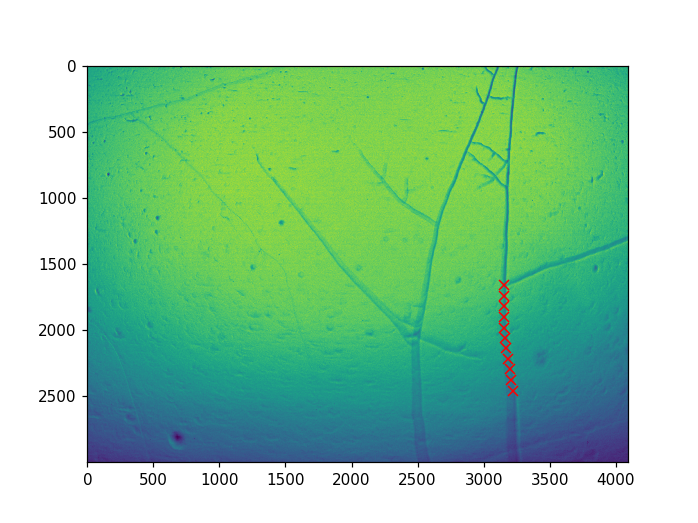

In [83]:
plot_edge(edge, 0)

## Brouillon

<IPython.core.display.Javascript object>


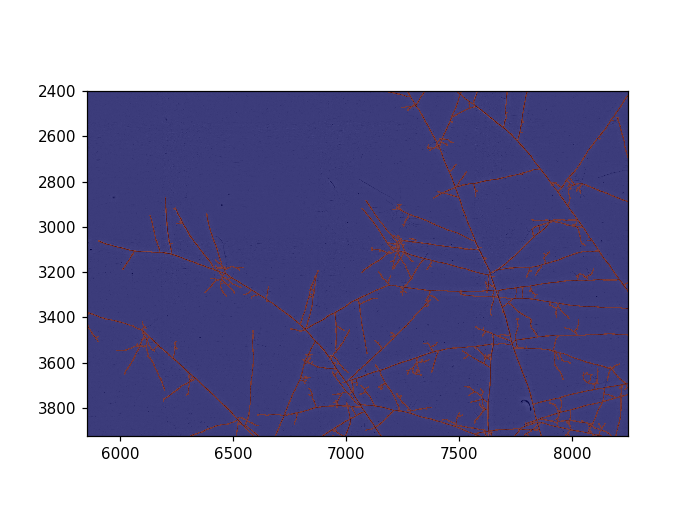

In [21]:
import numpy as np
from pymatreader import read_mat
import cv2
from amftrack.plotutil import plot_t_tp1

folder_list = list(selected_df['total_path'])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5,5),np.uint8)
itera = 1
start = 0

finish = start+2
for folder in folder_list[start:finish]:
    path_snap=folder
    skel_info = read_mat(path_snap+'/Analysis/skeleton_pruned_compressed.mat')
    skel = skel_info['skeleton']
    skels.append(cv2.dilate(skel.astype(np.uint8),kernel,iterations = itera))
    im = read_mat(path_snap+'/Analysis/raw_image.mat')['raw']
    ims.append(im)
    
%matplotlib notebook
plt.close('all')
start = 0
finish = start + 1
for i in range(start,finish):
    plot_t_tp1([], [], None, None, skels[i], ims[i])

<IPython.core.display.Javascript object>


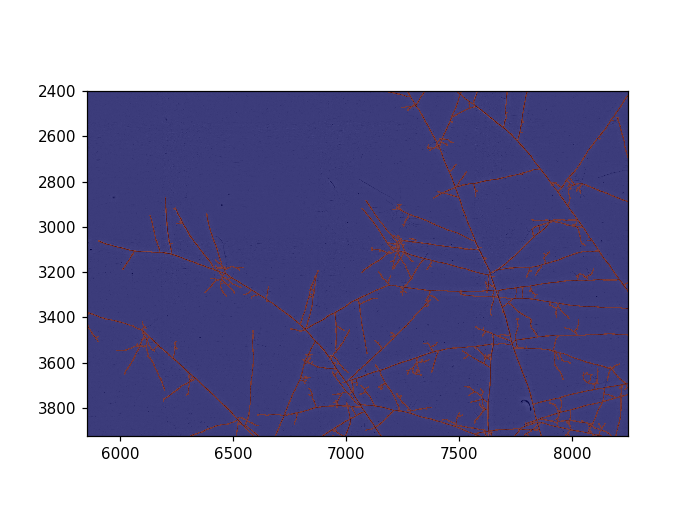

In [21]:
import numpy as np
from pymatreader import read_mat
import cv2
from amftrack.plotutil import plot_t_tp1

folder_list = list(selected_df['total_path'])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5,5),np.uint8)
itera = 1
start = 0

finish = start+2
for folder in folder_list[start:finish]:
    path_snap=folder
    skel_info = read_mat(path_snap+'/Analysis/skeleton_pruned_compressed.mat')
    skel = skel_info['skeleton']
    skels.append(cv2.dilate(skel.astype(np.uint8),kernel,iterations = itera))
    im = read_mat(path_snap+'/Analysis/raw_image.mat')['raw']
    ims.append(im)
    
%matplotlib notebook
plt.close('all')
start = 0
finish = start + 1
for i in range(start,finish):
    plot_t_tp1([], [], None, None, skels[i], ims[i])